<a href="https://colab.research.google.com/github/Aurelio-Naufal/KI_Task_Aurelio-Naufal-Effendy/blob/main/EndTermTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
puneet6060_intel_image_classification_path = kagglehub.dataset_download('puneet6060/intel-image-classification')
google_efficientnet_v2_tensorflow2_imagenet21k_b3_feature_vector_1_path = kagglehub.model_download('google/efficientnet-v2/TensorFlow2/imagenet21k-b3-feature-vector/1')

print('Data source import complete.')


# Aurelio Naufal Effendy (2106638526)
## Computational Intellegence

## Introduction    

### This is a step-by-step guide to building an image classification model using Google's EfficientNet V2 model.

### The dataset used has approximately 25,000 images (150x150 pixels), categorized into six distinct classes: buildings, forest, glacier, mountain, sea, street.

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import tensorflow_hub as hub

import os
import random
import shutil
from math import ceil, sqrt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Data    

In [ ]:
INPUT_DIR = "/kaggle/input/intel-image-classification/"
TRAIN_DIR = INPUT_DIR + "seg_train/seg_train"
TEST_DIR = INPUT_DIR + "seg_test/seg_test"
PRED_DIR = INPUT_DIR + "seg_pred/seg_pred"

## Visualizing images

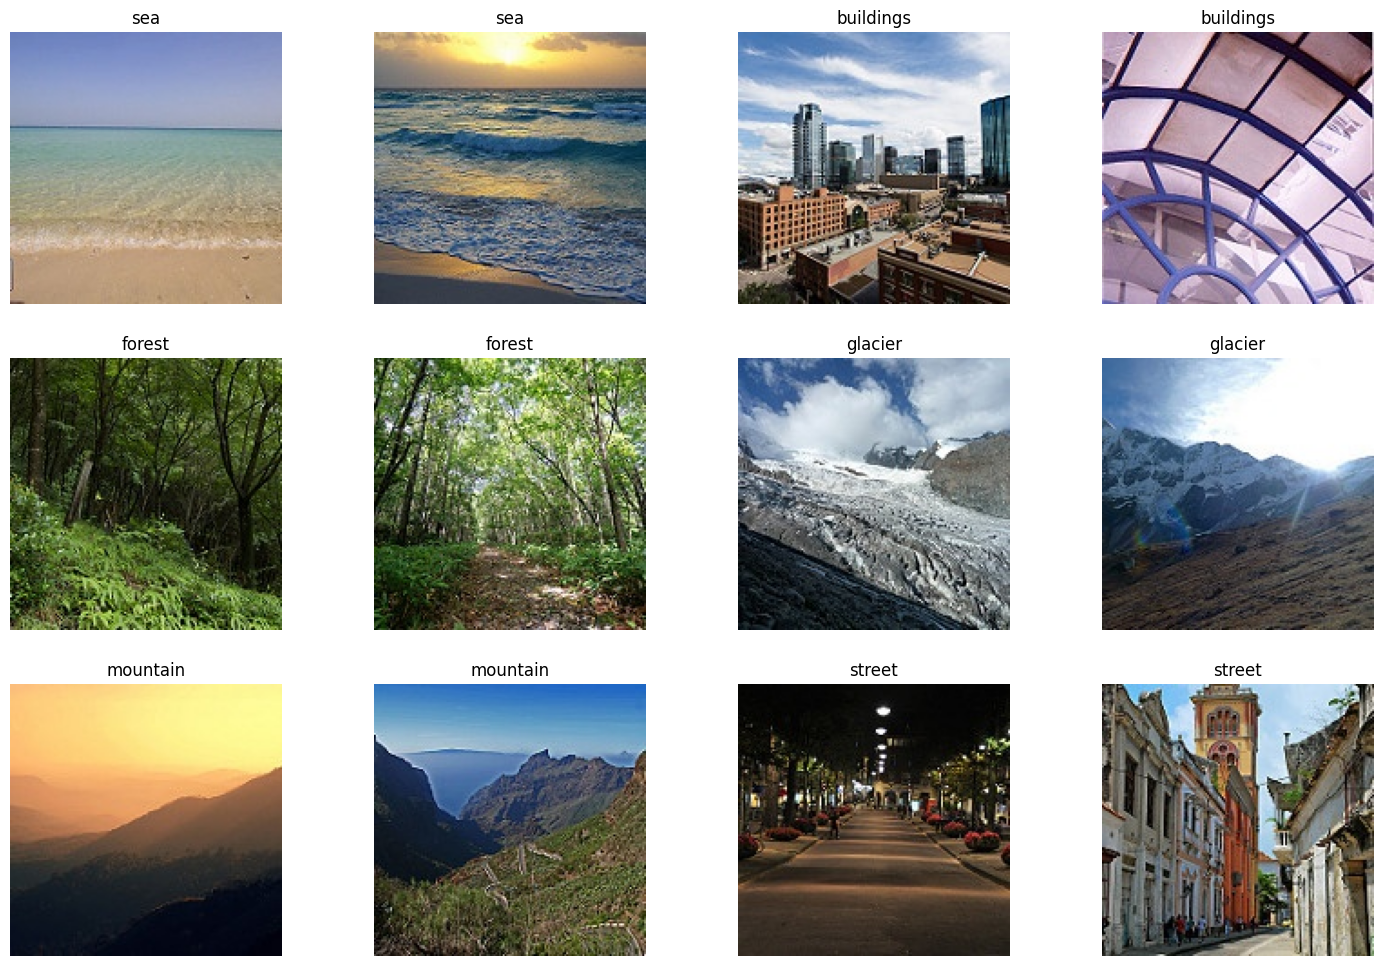

In [ ]:
# Define the image file paths
images = [
    TRAIN_DIR + "/sea/10016.jpg", TRAIN_DIR + "/sea/10041.jpg",
    TRAIN_DIR + "/buildings/10006.jpg", TRAIN_DIR + "/buildings/10014.jpg",
    TRAIN_DIR + "/forest/10007.jpg", TRAIN_DIR + "/forest/10010.jpg",
    TRAIN_DIR + "/glacier/10003.jpg", TRAIN_DIR + "/glacier/10009.jpg",
    TRAIN_DIR + "/mountain/10000.jpg", TRAIN_DIR + "/mountain/10002.jpg",
    TRAIN_DIR + "/street/10015.jpg", TRAIN_DIR + "/street/10019.jpg"
]

# Define the corresponding categories for each image
categories = [image.split("/")[-2] for image in images]

plt.figure(figsize=(18, 12))
for i in range(12):
    img = plt.imread(images[i])
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(categories[i])  # Display the category in the title
    plt.axis("off")
plt.show()

## EDA & Data preparation

Split images from the source directory into training and validation sets.

The following code takes images from a source directory and splits them into training and validation sets
based on a specified validation ratio.

In [ ]:
# Create the training and validation directories if they don't exist
train_dir = 'train'
valid_dir = 'val'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

for subdir in os.listdir(TRAIN_DIR):
    subdir_path = os.path.join(TRAIN_DIR, subdir)

    # Create corresponding subdirectories in train and val directories
    train_subdir = os.path.join(train_dir, subdir)
    valid_subdir = os.path.join(valid_dir, subdir)

    os.makedirs(train_subdir, exist_ok=True)
    os.makedirs(valid_subdir, exist_ok=True)

    all_images = os.listdir(subdir_path)

    num_validation = int(len(all_images) * 0.2)
    validation_images = random.sample(all_images, num_validation)

    for img in all_images:
        source_path = os.path.join(subdir_path, img)
        dest_dir = valid_subdir if img in validation_images else train_subdir
        dest_path = os.path.join(dest_dir, img)
        shutil.copy(source_path, dest_path)

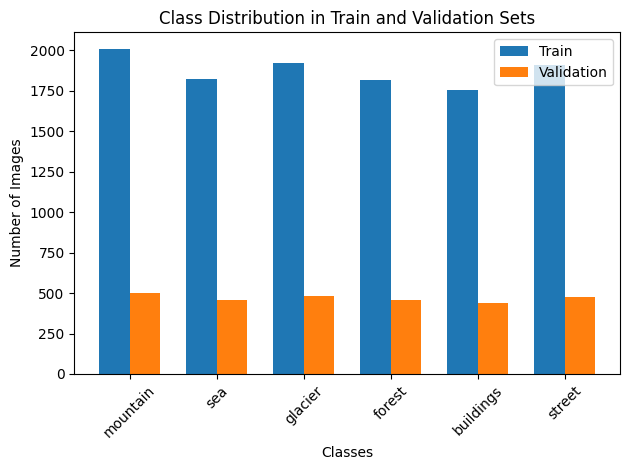

In [ ]:
import os
from collections import Counter

def get_class_distribution(directory):
    class_counts = {}
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            num_files = len(os.listdir(subdir_path))
            class_counts[subdir] = num_files
    return class_counts

def plot_class_distribution(train_dist, val_dist):
    classes = list(train_dist.keys())
    train_counts = list(train_dist.values())
    val_counts = [val_dist.get(cls, 0) for cls in classes]

    x = range(len(classes))
    width = 0.35

    plt.bar(x, train_counts, width, label='Train')
    plt.bar([p + width for p in x], val_counts, width, label='Validation')

    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution in Train and Validation Sets')
    plt.xticks([p + width / 2 for p in x], classes, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Get class distributions
train_dist = get_class_distribution('train')
val_dist = get_class_distribution('val')

# Plot the distributions
plot_class_distribution(train_dist, val_dist)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,      # Rescale pixel values to [0, 1]
    rotation_range=25,      # Randomly rotate images by up to 25 degrees
    width_shift_range=0.3,  # Randomly shift the width of images
    height_shift_range=0.3, # Randomly shift the height of images
    horizontal_flip=True,   # Randomly flip images horizontally
    shear_range=0.3,        # Apply shear transformations
    zoom_range=0.4,         # Randomly zoom into images
    fill_mode='nearest'     # Fill empty pixels with the nearest value
)

test_datagen = ImageDataGenerator(rescale = 1.0 / 255)
# Create data generators for training and validation data
batch_size = 32
image_size = (150, 150)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    '/kaggle/working/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=image_size,
    shuffle=False,
    class_mode='categorical',
    batch_size=1
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Model

In [ ]:
efficient_net = hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b3-feature-vector/versions/1",trainable=False)

model = keras.Sequential([
    efficient_net,
    keras.layers.Flatten(),  # Add a Flatten layer to reshape the output
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(6, activation='softmax'),
])

model.build((None, image_size[0], image_size[1], 3))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(5e-4, decay_steps=10000, decay_rate=0.9)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping( monitor='val_accuracy',patience=5,restore_best_weights=True)

In [ ]:
#Model Architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              12930622  
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [ ]:
#Train the model
history = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[early_stopping])

Epoch 1/50
351/351 [==============================] - 77s 180ms/step - loss: 0.7345 - accuracy: 0.7479 - val_loss: 0.3298 - val_accuracy: 0.8891
Epoch 2/50
351/351 [==============================] - 62s 176ms/step - loss: 0.4835 - accuracy: 0.8249 - val_loss: 0.2678 - val_accuracy: 0.9165
Epoch 3/50
351/351 [==============================] - 60s 172ms/step - loss: 0.4563 - accuracy: 0.8323 - val_loss: 0.2801 - val_accuracy: 0.9073
Epoch 4/50
351/351 [==============================] - 61s 172ms/step - loss: 0.4222 - accuracy: 0.8461 - val_loss: 0.2456 - val_accuracy: 0.9162
Epoch 5/50
351/351 [==============================] - 61s 172ms/step - loss: 0.3980 - accuracy: 0.8547 - val_loss: 0.2300 - val_accuracy: 0.9226
Epoch 6/50
351/351 [==============================] - 60s 171ms/step - loss: 0.3920 - accuracy: 0.8575 - val_loss: 0.2374 - val_accuracy: 0.9198
Epoch 7/50
351/351 [==============================] - 62s 175ms/step - loss: 0.3854 - accuracy: 0.8617 - val_loss: 0.2389 - val_ac

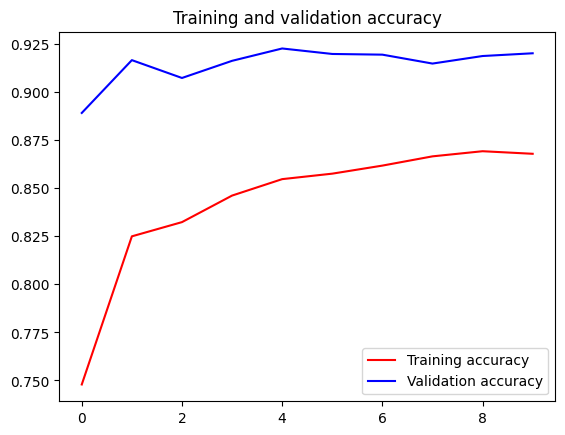

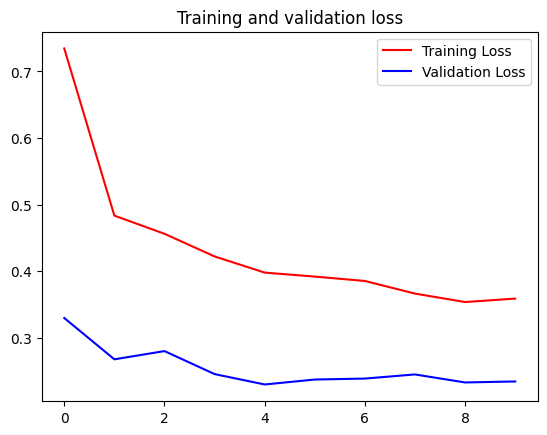

In [ ]:
#Model Training Perfromance
%matplotlib inline
acc_p = history.history['accuracy']
val_acc_p = history.history['val_accuracy']
loss_p = history.history['loss']
val_loss_p = history.history['val_loss']

epochs_p = range(len(acc_p))

plt.plot(epochs_p, acc_p, 'r', label='Training accuracy')
plt.plot(epochs_p, val_acc_p, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_p, loss_p, 'r', label='Training Loss')
plt.plot(epochs_p, val_loss_p, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Predictions

In [ ]:
#Predict using the model
predictions = model.predict(test_generator)
loss, accuracy = model.evaluate(test_generator)
print(f'Test loss: {loss:.4f}, accuracy: {accuracy:.4f}')

3000/3000 [==============================] - 34s 11ms/step - loss: 0.2163 - accuracy: 0.9247
Test loss: 0.2163, accuracy: 0.9247


## Error analysis
### Confusion matrix

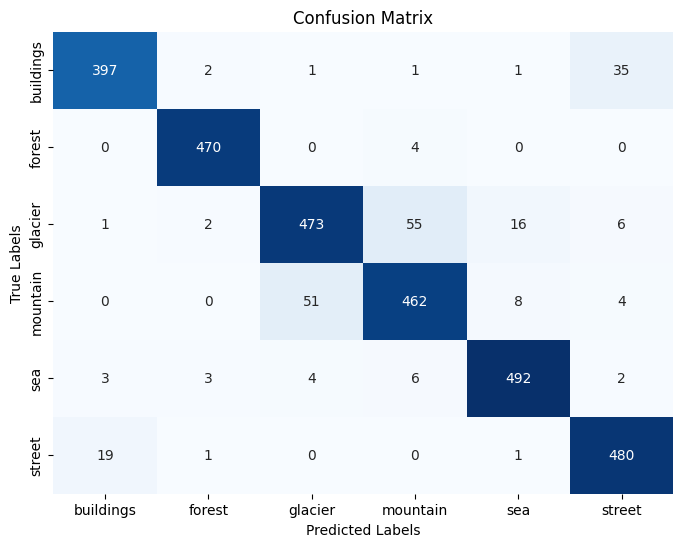

In [ ]:
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, np.argmax(predictions, axis=-1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

From the confusion matrix, it becomes apparent that there are occasional misclassifications between the "mountain" and "glacier" classes, as well as between the "street" and "buildings" classes. This is to be expected as glaciers may have mountains in the background and streets and building could both be in the same image. The overall performance of the model is good. Let's conduct a more detailed investigation about the misclassification.

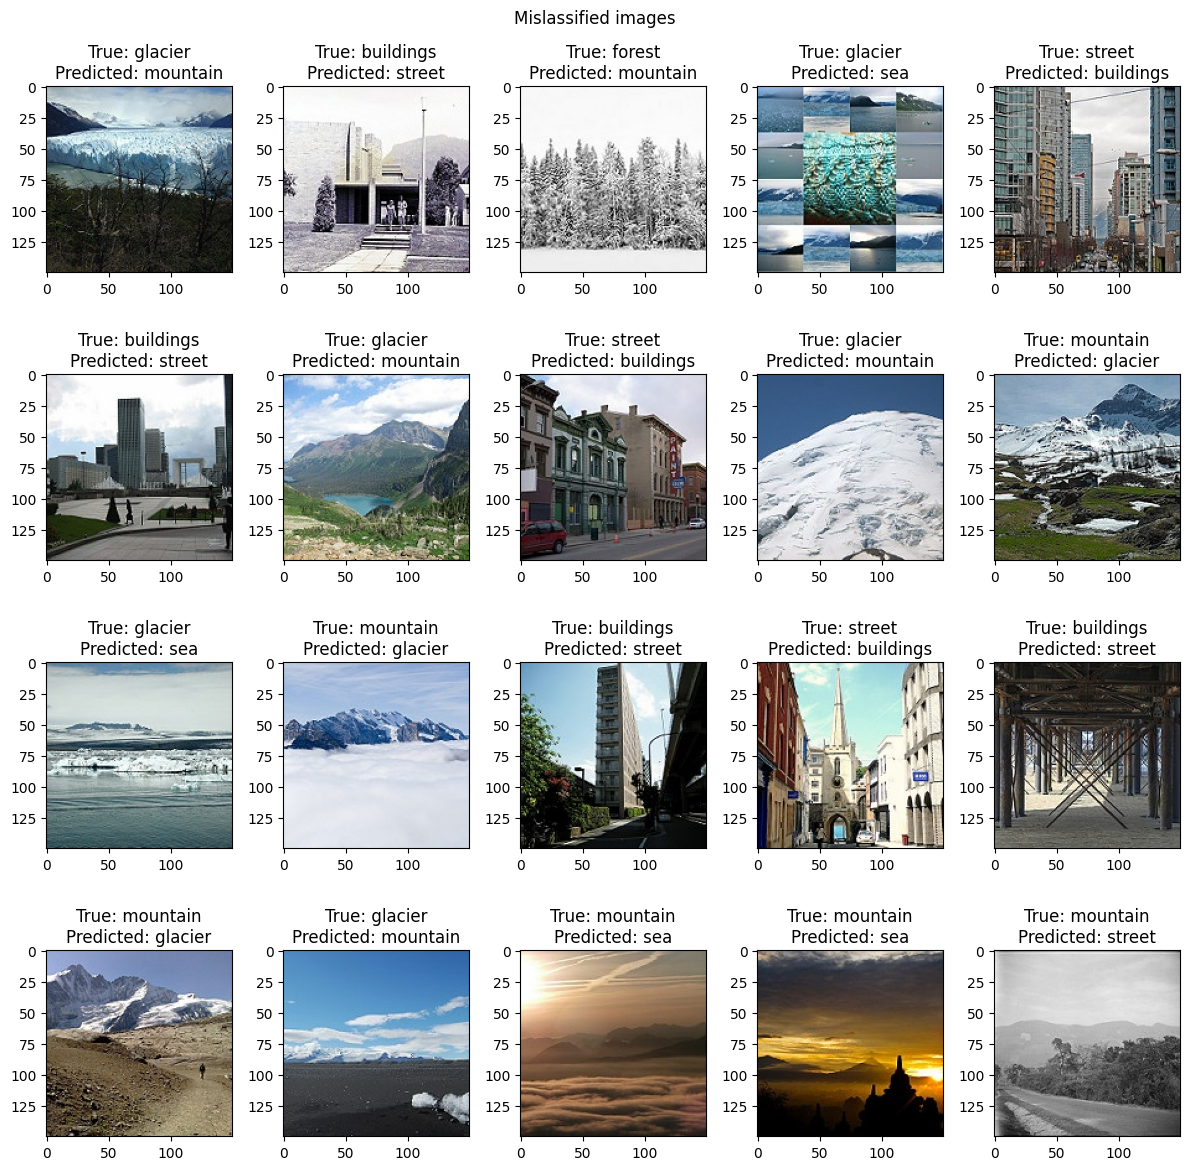

In [ ]:
misclassified_indices = np.where(np.argmax(predictions, axis=-1) != true_labels)[0]
np.random.shuffle(misclassified_indices)

num_images = min(len(misclassified_indices), 20)
num_cols = int(ceil(sqrt(num_images)))
num_rows = int(ceil(num_images / num_cols))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, idx in enumerate(misclassified_indices[:num_images]):
    true_class, predicted_class = true_labels[idx], np.argmax(predictions[idx])
    misclassified_image = plt.imread(test_generator.filepaths[idx])
    axs[i // num_cols, i % num_cols].imshow(misclassified_image)
    axs[i // num_cols, i % num_cols].set_title(f'True: {list(test_generator.class_indices.keys())[true_class]}\nPredicted: {list(test_generator.class_indices.keys())[predicted_class]}')

for i in range(num_images, num_rows * num_cols):
    axs[i // num_cols, i % num_cols].axis('off')

fig.suptitle("Mislassified images")
plt.tight_layout()
plt.show()

Clearly, quite a few of the misclassified images appear somewhat ambiguous. Our model is doing a good job.

For improving the architecture, it is essential to experiment with and explore alternative model architectures. EfficientNet offers various versions with more parameters, such as EfficientNet V2-S, M, L, and XL, which could be beneficial to try. Additionally, considering other CNN models may yield better results. Enhancements like adding more normalization layers and fine-tuning hyperparameters used during training could also improve performance. Moreover, the results indicate that some images appear ambiguous and can be classified into multiple categories. To address this, using a more updated and higher-quality dataset is recommended.